# Spatial Joins
Perform some spatial data wrangling on the airbnb data then load spatial data (boroughs, lsoa) and join the airbnb data to the spatial data.

In [56]:
# load packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [15]:
# load the clean airbnb data into a pandas dataframe
# get the current working directory
cwd = os.getcwd()
path = f"{cwd}/data/inside_airbnb/inside_airbnb_clean.csv"
# create a dataframe of the raw Inside Airbnb data
df = pd.read_csv(path, low_memory=False)

/home/jovyan/work/data/inside_airbnb/inside_airbnb_clean.csv


In [59]:
# create a geodataframe of the inside airbnb data, by defaults the crs is epsg 4326
# so also reproject the geodataframe to local crs - epsg: 27700
ab_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326')).to_crs('EPSG:27700')

# quickly plot the data
#ab_gdf.plot()

In [67]:
# Load London Borough shapefile - downloaded from "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
shp_path = os.path.join(cwd, "data", "london-boundaries", "statistical-gis-boundaries-london", "ESRI", "London_Borough_Excluding_MHW.shp")  

# read shapefile into geodataframe and reproject crs to 27700
boro_gdf = gpd.read_file(shp_path).to_crs('EPSG:27700')[['NAME', 'GSS_CODE', 'ONS_INNER', 'geometry']]

# quickly plot the data
#boro_gdf.plot()

In [88]:
# check the crs matches for both gdf
#print(f"ab has a crs of: [{ab_gdf.crs}]")
#print(f"ab has a crs of: [{boro_gdf.crs}]")

# remove any records that fall outside of the london boroughs boundary
ab_gdf_clipped = ab_gdf.clip(boro_gdf)

In [106]:
# counts the airbnb locations within each borough, split by room type
# set new gdf for each room type
entire_ab_gdf = ab_gdf[ab_gdf['room_type'] == "Entire home/apt"]
pr_ab_gdf = ab_gdf[ab_gdf['room_type'] == "Private room"]
other_ab_gdf = ab_gdf[~ab_gdf['room_type'].isin(["Entire home/apt", "Private room"])]

# create point counts per borough
c1 = boro_gdf.join(gpd.sjoin(ab_gdf, boro_gdf).groupby("index_right").size().rename("total_airbnbs"))
c2 = c1.join(gpd.sjoin(entire_ab_gdf, c1).groupby("index_right").size().rename("total_entireha"))
c3 = c2.join(gpd.sjoin(pr_ab_gdf, c2).groupby("index_right").size().rename("total_privateroom"))
boro_count_gdf = c3.join(gpd.sjoin(other_ab_gdf, c3).groupby("index_right").size().rename("total_other"))
# replaces NaN values with zero
boro_count_gdf['total_other'] = boro_count_gdf['total_other'].fillna(0).astype('int64')

print(boro_count_gdf)

                      NAME   GSS_CODE ONS_INNER  \
0     Kingston upon Thames  E09000021         F   
1                  Croydon  E09000008         F   
2                  Bromley  E09000006         F   
3                 Hounslow  E09000018         F   
4                   Ealing  E09000009         F   
5                 Havering  E09000016         F   
6               Hillingdon  E09000017         F   
7                   Harrow  E09000015         F   
8                    Brent  E09000005         F   
9                   Barnet  E09000003         F   
10                 Lambeth  E09000022         T   
11               Southwark  E09000028         T   
12                Lewisham  E09000023         T   
13               Greenwich  E09000011         F   
14                  Bexley  E09000004         F   
15                 Enfield  E09000010         F   
16          Waltham Forest  E09000031         F   
17               Redbridge  E09000026         F   
18                  Sutton  E09

(155000.0, 202000.0)

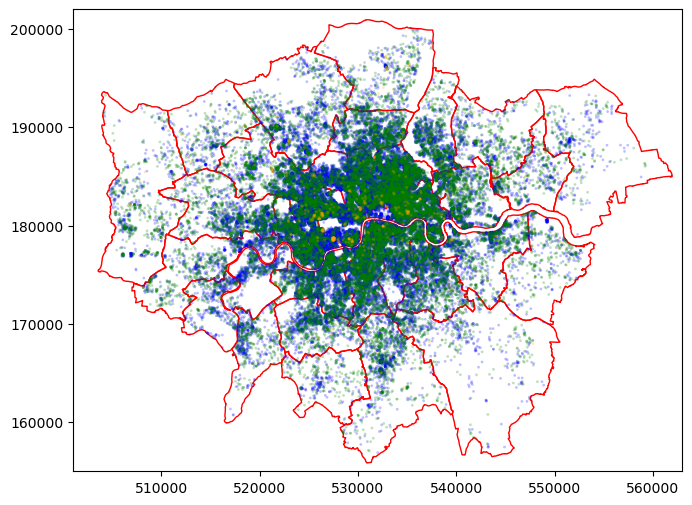

In [122]:
# Creates a new figure with specified number of
# subplots (we'll see more of this later) and 
# and the specified size (in inches by default).
fig, ax = plt.subplots(1,1, figsize=(8,6))

# Plot all borough and airbnb data to the same axes
boro_gdf.plot(edgecolor='red', facecolor='none', ax=ax)
entire_ab_gdf.plot(edgecolor='blue', facecolor='none', ax=ax,alpha=0.25, markersize=1.0)
pr_ab_gdf.plot(edgecolor='green', facecolor='none', ax=ax, alpha=0.25, markersize=1.0)
other_ab_gdf.plot(edgecolor='orange', facecolor='none', ax=ax, alpha=0.25, markersize=1.0)

# Set the x and y limits
ax.set_xlim(501000, 563000)
ax.set_ylim(155000, 202000)

# Save the image (dpi is 'dots per inch')
#os.makedirs('img', exist_ok=True)
#plt.savefig(os.path.join('img','borough_map_with_air_bnb_locations.png'), dpi=150)

Due to the relatively low counts of "other" room types we can discount these from our analysis and focus on "Entire Home/apts" and "Private rooms"

In [139]:
# drop the other count column from the gdf
boro_count_gdf = boro_count_gdf.drop(columns=['total_other'])

In [142]:
# normalise the counts by area
# create an area columns
boro_count_gdf['area'] = boro_count_gdf.geometry.area

# Normalize the remaining count columns by dividing by the calculated area
boro_count_gdf['normalised_count_entireha'] = boro_count_gdf['total_entireha'] / boro_count_gdf['area']
boro_count_gdf['normalised_count_privateroom'] = boro_count_gdf['total_privateroom'] / boro_count_gdf['area']

# Display the updated GeoDataFrame to see the new column
print(boro_count_gdf[['total_entireha', 'area', 'normalised_count_entireha']].head())
print(boro_count_gdf[['total_privateroom', 'area', 'normalised_count_privateroom']].head())

   total_entireha          area  normalised_count_entireha
0             396  3.726118e+07                   0.000011
1             786  8.649444e+07                   0.000009
2             421  1.501349e+08                   0.000003
3             734  5.592623e+07                   0.000013
4            1225  5.554435e+07                   0.000022
   total_privateroom          area  normalised_count_privateroom
0                298  3.726118e+07                      0.000008
1                715  8.649444e+07                      0.000008
2                346  1.501349e+08                      0.000002
3                528  5.592623e+07                      0.000009
4                940  5.554435e+07                      0.000017


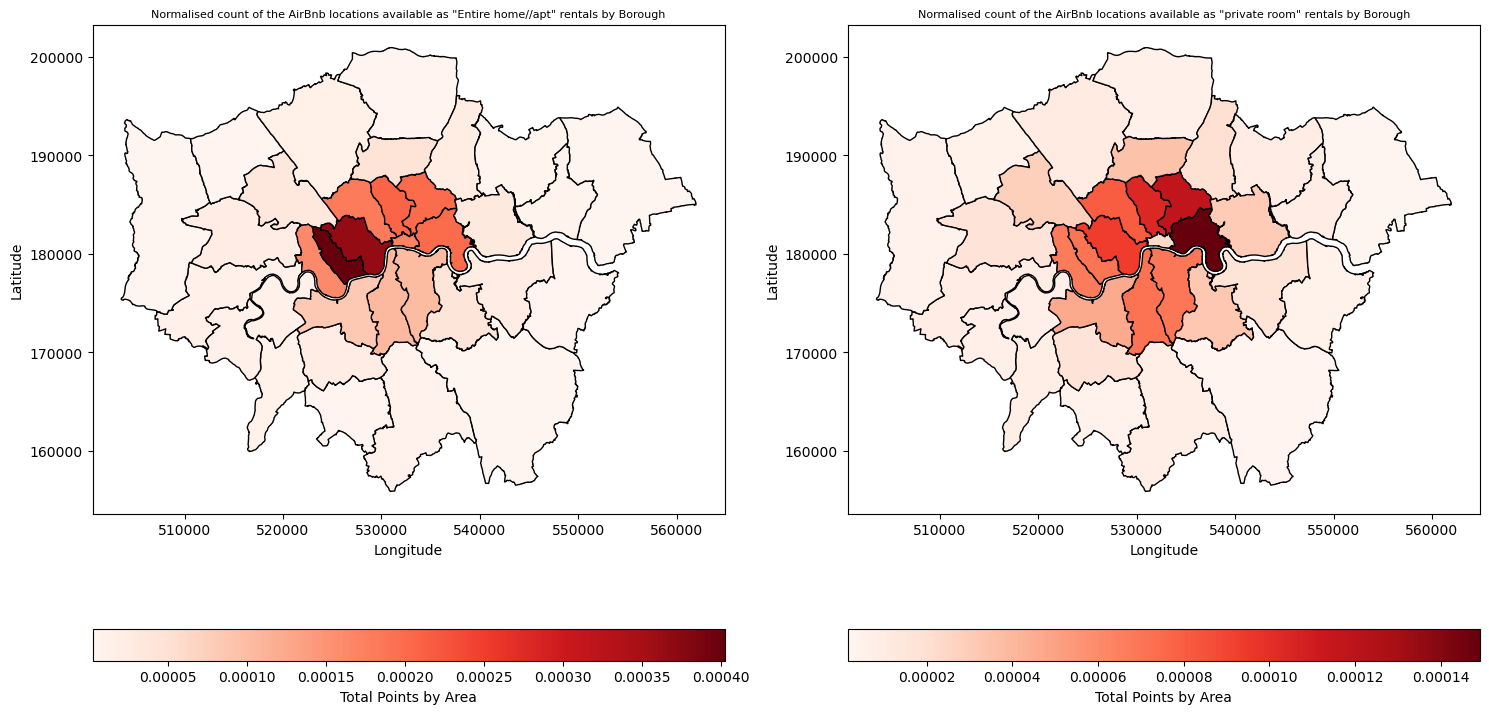

In [154]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot using 'total_other' as the value for coloring
boro_count_gdf.plot(column='normalised_count_entireha', ax=axes[0], legend=True,
                    legend_kwds={'label': "Total Points by Area",
                                 'orientation': "horizontal"},
                    cmap='Reds', edgecolor='black')

# Add title and labels
axes[0].set_title("Normalised count of the AirBnb locations available as \"Entire home//apt\" rentals by Borough", fontsize=8)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

boro_count_gdf.plot(column='normalised_count_privateroom', ax=axes[1], legend=True,
                    legend_kwds={'label': "Total Points by Area",
                                 'orientation': "horizontal"},
                    cmap='Reds', edgecolor='black')

# Add title and labels
axes[1].set_title("Normalised count of the AirBnb locations available as \"private room\" rentals by Borough", fontsize=8)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# Show the plot
plt.tight_layout()
plt.show()